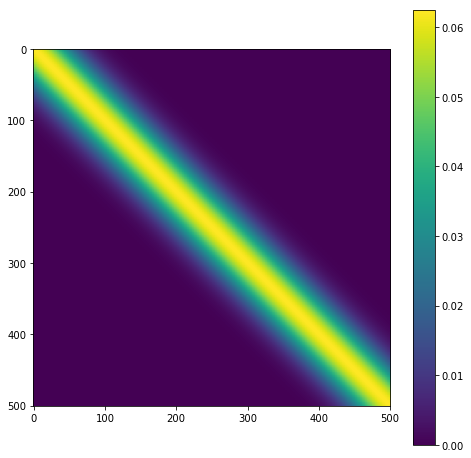

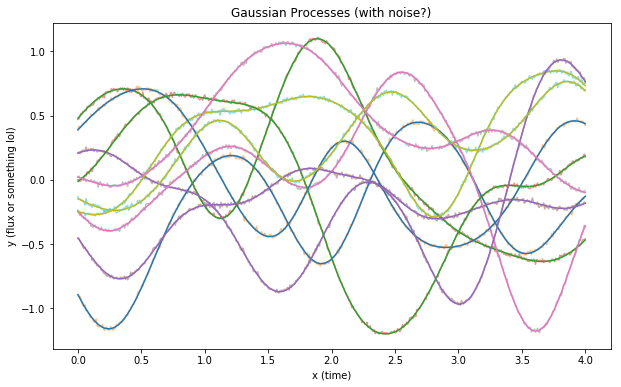

In [15]:
#based heavily on information found from
#https://ericschulz.github.io/publications/Schulz2017tutorial.pdf
#"A tutorial on Gaussian process regression: Modelling, exploring, and exploiting functions"

import numpy as np
from numpy.random import normal, seed, uniform
from scipy.optimize import minimize
import matplotlib.pyplot as plt
%matplotlib inline

#Setting a random seed so final results can be reproduced
seed(2)

#"true" underlying function for the fake obsevations
def observations(x,measurement_noise):
    
    #a phase shifted sine curve with noise
    shift = uniform(high=2*np.pi)
    return np.array([np.sin(np.pi/2*i+shift)+measurement_noise**2*normal() for i in x])

#the kernel function that defines how correlated points are to each other based on their position
def kernel(kernel_amplitude,kernel_length,x1,x2):
    
    #Radial basis function (~gaussian) #things are more correlated the closer they are
    #see page 12 of the linked pdf to see functional form in nice LaTeX
    
    #converting inputs to arrays and finding their squared differences
    x1a=np.array(x1)
    x2a=np.array(x2)
    dif=x1a-x2a
    dif_sq=np.dot(dif,dif)
    
    return kernel_amplitude**2*np.exp(-dif_sq/(2*kernel_length**2))

#evalutes the kernel function for each pair of passed inputs
def covariance(x1list,x2list,kernel_amplitude,kernel_length):
    K=np.zeros((len(x1list),len(x2list)))
    for i, x1 in enumerate(x1list):
        for j, x2 in enumerate(x2list):
            K[i,j]=kernel(kernel_amplitude,kernel_length,x1,x2)
    return K

#kernel hyper parameters (AFFECTS HOW TALL AND WIDE GP's ARE)
kernel_amplitude=.25 #called the signal variance
kernel_length=0.3 #called the lengthscale

#Uncertainty in the data (AFFECTS SPREAD OF DATA AND HOW TIGHTLY THE GP's WILL TRY TO HUG THE DATA)
measurement_noise=.1 #how much noise is added to measurements and measurement covariance function

#how finely to sample the domain
GP_sample_amount=500+1

#creating many inputs to sample the eventual gaussian process on
x_samp=np.linspace(0,4,GP_sample_amount)

#Finding how correlated the sampled inputs are to each other
#(aka getting the covariance matrix by evaluating the kernel function at all pairs of points)
K_samp=covariance(x_samp,x_samp,kernel_amplitude,kernel_length)        

#plot the evaluated covariance matrix (colors show how correlated points are to each other)
plt.figure(figsize=(8,8))
plt.imshow(K_samp)
plt.colorbar()
plt.show()

#creating observations to test methods on
amount_of_measurements=9
domain=4 #how wide the measurement domain is
x_obs=np.linspace(0,domain,amount_of_measurements) #observation inputs
y_obs=observations(x_obs,measurement_noise) #observation outputs

#plotting some randomly drawn Gaussian processes using the kernel function to correlate points
plt.figure(figsize=(10,6))
for i in range(10):
    #sampled possible GP function values
    GP_func=np.matmul(K_samp,normal(size=GP_sample_amount)) 
    plt.plot(x_samp,GP_func, zorder=2)
    
    #sampled possible GP observations (that have noise)
    GP_obs=GP_func+measurement_noise**2*normal(size=GP_sample_amount) 
    plt.plot(x_samp,GP_obs, alpha=0.5, zorder=1)
    
#plt.scatter(x_obs,y_obs,color="black", zorder=3)
plt.xlabel("x (time)")
plt.ylabel("y (flux or something lol)")
plt.title("Gaussian Processes (with noise?)")
plt.show()

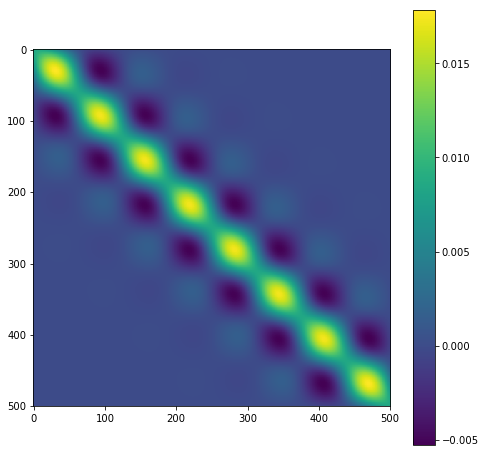

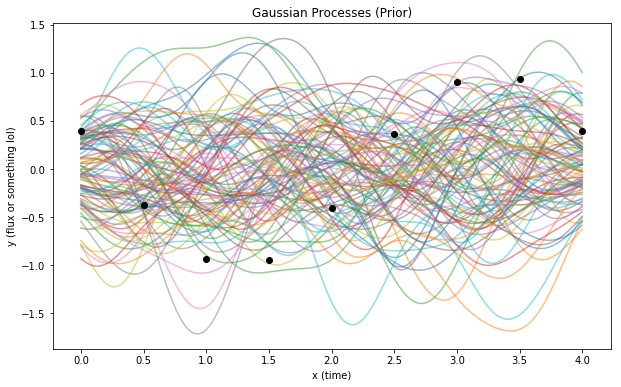

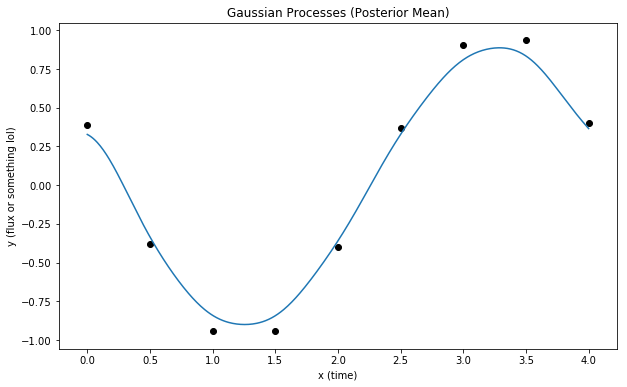

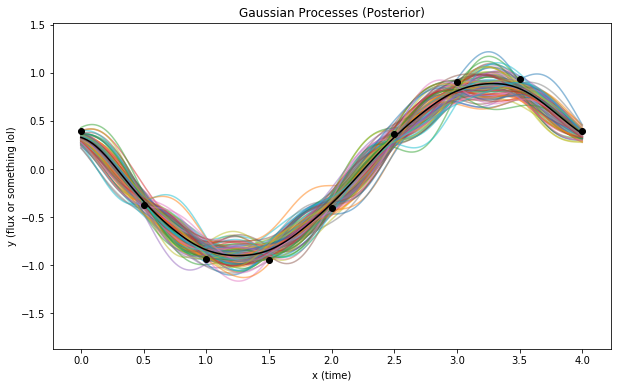

In [12]:
#creating additional covariance matrices (as defined on page 13)
noise_I=np.identity(amount_of_measurements)*measurement_noise**2
K_obs=covariance(x_obs,x_obs,kernel_amplitude,kernel_length)+noise_I
K_samp_obs=covariance(x_samp,x_obs,kernel_amplitude,kernel_length) 
K_obs_samp=covariance(x_obs,x_samp,kernel_amplitude,kernel_length)

#mean of the conditional distribution p(f_samp|x_obs,t_obs,x_samp) (as defined on page 14)
mean_post=np.matmul(K_samp_obs,np.matmul(np.linalg.inv(K_obs),y_obs))
#cavariance matrix of the conditional distribution p(f_samp|x_obs,t_obs,x_samp) (as defined on page 14)
K_post=K_samp-np.matmul(K_samp_obs,np.matmul(np.linalg.inv(K_obs),K_obs_samp))

#plot the posterior covariance matrix (colors show how correlated points are to each other)
plt.figure(figsize=(8,8))
plt.imshow(K_post)
plt.colorbar()
plt.show()

#plotting some more randomly drawn Gaussian processes before data influences the posterior
plt.figure(figsize=(10,6))
for i in range(100):
    f=np.matmul(K_samp,normal(size=GP_sample_amount))
    plt.plot(x_samp,f, alpha=0.5, zorder=1)
plt.scatter(x_obs,y_obs,color="black", zorder=2)
ymin, ymax = plt.ylim()
plt.xlabel("x (time)")
plt.ylabel("y (flux or something lol)")
plt.title("Gaussian Processes (Prior)")
plt.show()

#plotting the mean function of the posterior
plt.figure(figsize=(10,6))
plt.plot(x_samp,mean_post)
plt.scatter(x_obs,y_obs,color="black")
plt.xlabel("x (time)")
plt.ylabel("y (flux or something lol)")
plt.title("Gaussian Processes (Posterior Mean)")
plt.show()

#plotting randomly drawn Gaussian processes with the mean function and covariance of the posterior
#much closer to the data, no? (still has behvaior at timescales that are too low though)
plt.figure(figsize=(10,6))
for i in range(100):
    f=np.matmul(K_post,normal(size=GP_sample_amount))+mean_post
    plt.plot(x_samp,f, alpha=0.5, zorder=1)
plt.plot(x_samp,mean_post, color="black", zorder=2)
plt.scatter(x_obs,y_obs,color="black",zorder=2)
plt.ylim(ymin, ymax)
plt.xlabel("x (time)")
plt.ylabel("y (flux or something lol)")
plt.title("Gaussian Processes (Posterior)")
plt.show()

In [13]:
#negative log likelihood of the data given the current kernel parameters (as seen on page 19)
#(negative because scipy has a minimizer instead of a maximizer)
def nlogL(hyperparameters):
    kernel_amplitude=hyperparameters[0]
    kernel_length=hyperparameters[1]
    n=len(y_obs)
    K_obs=covariance(x_obs,x_obs,kernel_amplitude,kernel_length)+np.identity(amount_of_measurements)*measurement_noise**2
    
    #goodness of fit term
    data_fit=-1/2*np.matmul(np.transpose(y_obs),np.matmul(np.linalg.inv(K_obs),y_obs))
    #complexity penalization term
    penalty=-1/2*np.log(np.linalg.det(K_obs))
    #normalization term (functionally useless)
    normalization=-n/2*np.log(2*np.pi)
    return -1*(data_fit+penalty+normalization)

#numerically maximize the likelihood to find the best hyperparameters
result=minimize(nlogL, [kernel_amplitude,kernel_length])
print(result)

      fun: 1.8815697491876984
 hess_inv: array([[ 0.2450945 ,  0.1391517 ],
       [ 0.1391517 ,  0.11613325]])
      jac: array([ -6.55651093e-07,   2.68220901e-06])
  message: 'Optimization terminated successfully.'
     nfev: 56
      nit: 10
     njev: 14
   status: 0
  success: True
        x: array([ 0.93973827,  1.10669336])


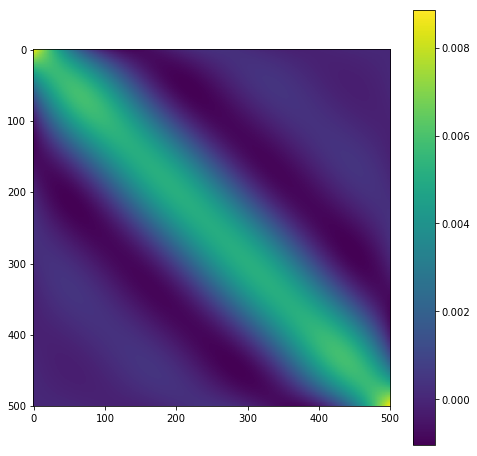

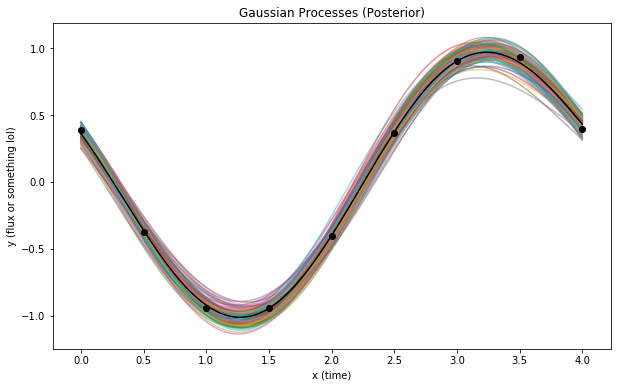

In [14]:
#reruning analysis of posterior with the "most likley" kernel amplitude and lengthscale
kernel_amplitude,kernel_length=result.x

#recalculating covariance matrices
K_samp=covariance(x_samp,x_samp,kernel_amplitude,kernel_length) 
noise_I=np.identity(amount_of_measurements)*measurement_noise**2
K_obs=covariance(x_obs,x_obs,kernel_amplitude,kernel_length)+noise_I
K_samp_obs=covariance(x_samp,x_obs,kernel_amplitude,kernel_length) 
K_obs_samp=covariance(x_obs,x_samp,kernel_amplitude,kernel_length)

#mean of the conditional distribution p(f_samp|x_obs,t_obs,x_samp) (as defined on page 14)
mean_post=np.matmul(K_samp_obs,np.matmul(np.linalg.inv(K_obs),y_obs))
#cavariance matrix of the conditional distribution p(f_samp|x_obs,t_obs,x_samp) (as defined on page 14)
K_post=K_samp-np.matmul(K_samp_obs,np.matmul(np.linalg.inv(K_obs),K_obs_samp))

#plot the posterior covariance of the "most likely" posterior matrix 
#(colors show how correlated points are to each other)
plt.figure(figsize=(8,8))
plt.imshow(K_post)
plt.colorbar()
plt.show()

#plotting randomly drawn Gaussian processes with the mean function and 
#covariance of the "most likely" posterior
plt.figure(figsize=(10,6))
for i in range(100):
    f=np.matmul(K_post,normal(size=GP_sample_amount))+mean_post
    plt.plot(x_samp,f, alpha=0.5, zorder=1)
plt.plot(x_samp,mean_post, color="black", zorder=2)
plt.scatter(x_obs,y_obs,color="black",zorder=2)
plt.xlabel("x (time)")
plt.ylabel("y (flux or something lol)")
plt.title("Gaussian Processes (Posterior)")
plt.show()